<div>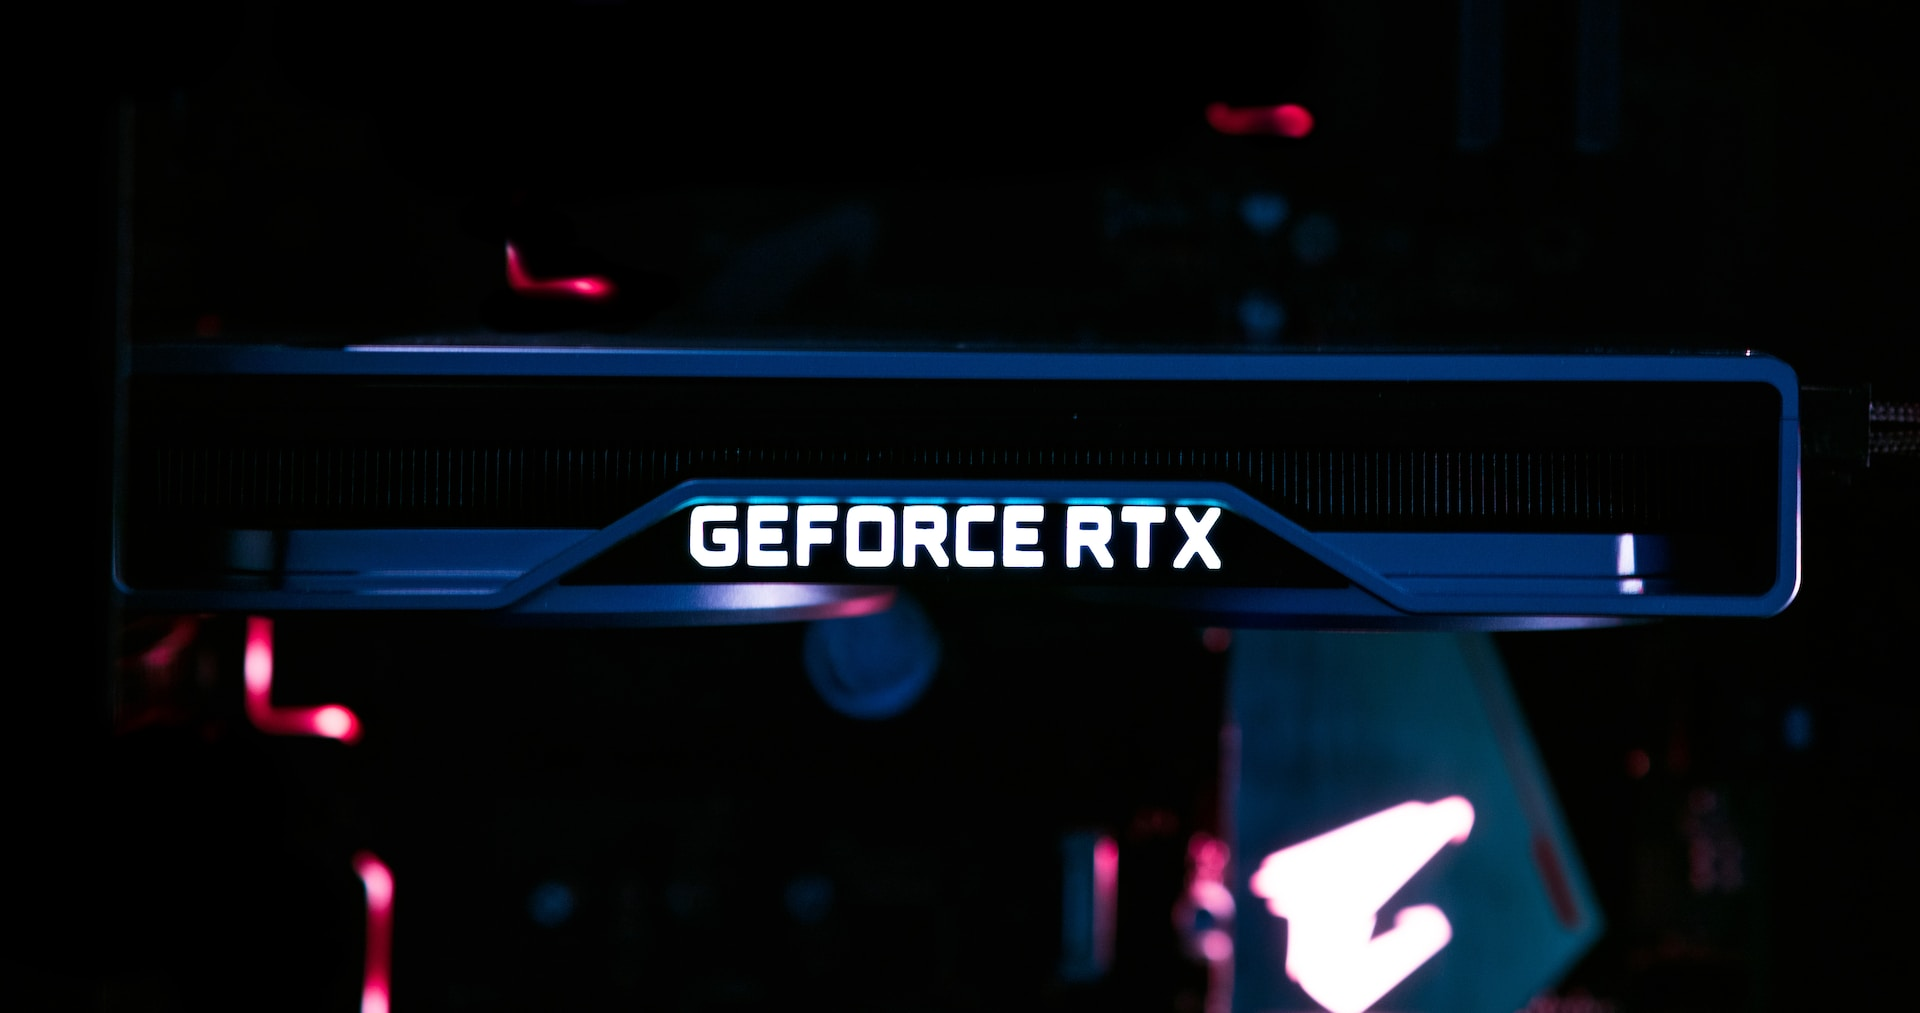</div>
<div style="text-align: right; font-size: 10px; color: grey; margin-bottom: 2em;">Source: Photo by <a style="color: grey;" href="https://unsplash.com/@lucaskphoto?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Lucas Kepner</a> on <a style="color: grey;" href="https://unsplash.com/photos/a-close-up-of-a-sign-in-the-dark-vJ3Lt-mcGP4?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Unsplash</a></div>

This notebook is a step-by-step guide to fine-tuning, compiling and serving a Llama 2 7B model for dialogue summarization on a 12GB consumer graphics card.
We'll use `SFTTrainer` from `trl` for fine-tuning, and use [mlc-llm](https://github.com/mlc-ai/mlc-llm) to compile and serve the fine-tuned model.
The training dataset is [SAMSum](https://huggingface.co/datasets/samsum), which can be downloaded from 🤗 Hugging Face.

## 0. Set up the environment

In [ ]:
!pip install \
accelerate==0.23.0 bitsandbytes==0.41.1 datasets==2.13.0 openai==0.28.1 \
peft==0.4.0 safetensors==0.4.0 transformers==4.34.0 trl==0.4.7

## 1. Load the SAMSum dataset
The [SAMSum](https://huggingface.co/datasets/samsum) dataset is a collection of about 16k messenger-like conversations with human-written summaries. 
It is intended for the task of abstractive dialogue summarization, which aims to generate a concise and informative summary of a dialogue.

We'll only load the first 1k training samples for demonstration purposes

In [ ]:
from datasets import load_dataset

# load 1k samples from the train split
train_dataset = load_dataset("samsum", split='train[:1000]')

In [4]:
print(train_dataset)

Dataset({
    features: ['id', 'dialogue', 'summary'],
    num_rows: 1000
})


In [3]:
train_dataset[0]

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}

## 2. Load and fine-tune the model with QLoRA

QLoRA [@dettmers2023qlora] is an efficient fine-tuning method for LLMs that reduces memory usage while preserving the performance of full 16-bit fine-tuning. It backpropagates gradients through a frozen, 4-bit quantized pre-trained model into Low Rank Adapters (LoRA). 
LoRA adapters are trainable rank decomposition matrices injected into each layer of the Transformer architecture, which reduce the number of trainable parameters for downstream tasks. QLoRA has the following components:

- 4-bit NormalFloat (NF4) Quantization: the NormalFloat data type is optimal for zero-centered normally distributed data.
- Double Quantization: a technique for additional memory savings.
- Paged Optimizers: swap optimizer states between CPU and GPU using NVIDIA unified memory to prevent GPU out of memory errors.

### load and prepare the model for 4bit training

In [1]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training

model_id = "meta-llama/Llama-2-7b-chat-hf"

# 
# load model in NF4 quantization with double quantization,
# set compute dtype to bfloat16
# 
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    use_cache=False,
    device_map="auto",
)
model = prepare_model_for_kbit_training(model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### use `SFTTrainer` from `trl` for training
#### First, define a utility function to format prompts.

In [7]:
def prompt_formatter(sample):
	return f"""<s>### Instruction:
You are a helpful, respectful and honest assistant. \
Your task is to summarize the following dialogue. \
Your answer should be based on the provided dialogue only.

### Dialogue:
{sample['dialogue']}

### Summary:
{sample['summary']} </s>"""

n = 0
print(prompt_formatter(train_dataset[n]))

<s>### Instruction:
You are a helpful, respectful and honest assistant. Your task is to summarize the following dialogue. Your answer should be based on the provided dialogue only.

### Dialogue:
Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)

### Summary:
Amanda baked cookies and will bring Jerry some tomorrow. </s>


#### Then, set up a trainer and train.

In [8]:
from transformers import TrainingArguments, AutoTokenizer
from peft import LoraConfig, get_peft_model
from trl import SFTTrainer

# 
# construct a Peft model.
# the QLoRA paper recommends LoRA dropout = 0.05 for small models (7B, 13B)
# 
peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM", 
)
model = get_peft_model(model, peft_config)

# 
# set up the trainer
# 
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

args = TrainingArguments(
    output_dir="llama2-7b-chat-samsum",
    num_train_epochs=2,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    logging_steps=4,
    save_strategy="epoch",
    learning_rate=2e-4,
    optim="paged_adamw_32bit",
    bf16=True,
    fp16=False,
    tf32=True,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    disable_tqdm=False,
)
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    peft_config=peft_config,
    max_seq_length=1024,
    tokenizer=tokenizer,
    packing=True,
    formatting_func=prompt_formatter, 
    args=args,
)

In [9]:
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/vol04/llmenv/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
4,2.386100
8,2.089200
12,1.910900
16,1.789500
20,1.757300
24,1.767600
28,1.779400
32,1.685600
36,1.703700
40,1.661000


/vol04/llmenv/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


TrainOutput(global_step=64, training_loss=1.7523600682616234, metrics={'train_runtime': 1430.7677, 'train_samples_per_second': 1.398, 'train_steps_per_second': 0.175, 'total_flos': 2.063561480208384e+16, 'train_loss': 1.7523600682616234, 'epoch': 1.26})

During training, the GPU memory usage was around 11GB.

<div style="text-align:center;">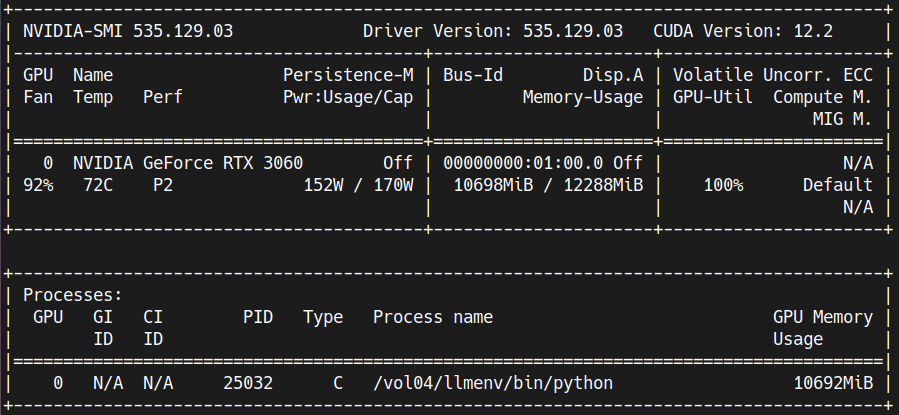
</div>

#### Save the adapter model

In [11]:
trainer.save_model()

## 3. Run inference using the fine-tuned model

In [ ]:
from datasets import load_dataset
from random import randrange

dataset = load_dataset("samsum", split='validation')

### load the adapter and the base model

In [2]:
import torch
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer

model_folder = "llama2-7b-chat-samsum"

# load both the adapter and the base model
model = AutoPeftModelForCausalLM.from_pretrained(
    model_folder,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    load_in_4bit=True,
    device_map='auto'
)
tokenizer = AutoTokenizer.from_pretrained(model_folder)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear4bit(
                in_features=4096, out_features=4096, bias=False
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
              (v_proj): Linear4

### pick a sample, construct a prompt and send it to the model

In [6]:
sample = dataset[10]

prompt = f"""### Instruction:
You are a helpful, respectful and honest assistant. \
Your task is to summarize the following dialogue. \
Your answer should be based on the provided dialogue only.

### Dialogue:
{sample['dialogue']}

### Summary:
"""
print(prompt)

### Instruction:
You are a helpful, respectful and honest assistant. Your task is to summarize the following dialogue. Your answer should be based on the provided dialogue only.

### Dialogue:
Laura: I need a new printer :/
Laura: thinking about this one
Laura: <file_other>
Jamie: you're sure you need a new one?
Jamie: I mean you can buy a second hand one
Laura: could be

### Summary:



In [27]:
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.cuda()
outputs = model.generate(input_ids=input_ids, max_new_tokens=50, temperature=0.7)

print('Output:\n',
      tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):])
print('\nGround truth:\n', sample['summary'])

Output:
 Laura is looking for a new printer. She is considering buying a second hand one. 

Ground truth:
 Laura is going to buy a printer.


## 4. Merge and save the fine-tuned model

In [1]:
import torch
from peft import AutoPeftModelForCausalLM

model_folder = "llama2-7b-chat-samsum"

model = AutoPeftModelForCausalLM.from_pretrained(
    model_folder,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16
)

# merge the lora adapter and the base model
merged_model = model.merge_and_unload()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
from transformers import AutoTokenizer

output_folder = 'merged-llama2-7b-chat-samsum'

# save the merged model and the tokenizer
merged_model.save_pretrained(output_folder, safe_serialization=True)

tokenizer = AutoTokenizer.from_pretrained(model_folder)
tokenizer.save_pretrained(output_folder)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


('merged-llama2-7b-chat-samsum/tokenizer_config.json',
 'merged-llama2-7b-chat-samsum/special_tokens_map.json',
 'merged-llama2-7b-chat-samsum/tokenizer.json')

## 5. Run inference using the merged model

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

model_folder = 'merged-llama2-7b-chat-samsum'

tokenizer = AutoTokenizer.from_pretrained(model_folder)

model = AutoModelForCausalLM.from_pretrained(
    model_folder,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    load_in_4bit=True,
    device_map="auto",
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm

In [8]:
from transformers import pipeline, GenerationConfig

gen_config = GenerationConfig.from_pretrained(model_folder)
gen_config.max_new_tokens = 50
gen_config.temperature = 0.7
gen_config.repetition_penalty = 1.1
gen_config.pad_token_id = tokenizer.eos_token_id

pipe = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map='auto',
    generation_config=gen_config,
)

In [ ]:
from datasets import load_dataset
from random import randrange

dataset = load_dataset("samsum", split='validation')

In [12]:
sample = dataset[10]

prompt = f"""### Instruction:
You are a helpful, respectful and honest assistant. \
Your task is to summarize the following dialogue. \
Your answer should be based on the provided dialogue only.

### Dialogue:
{sample['dialogue']}

### Summary:
"""
print(prompt)

### Instruction:
You are a helpful, respectful and honest assistant. Your task is to summarize the following dialogue. Your answer should be based on the provided dialogue only.

### Dialogue:
Laura: I need a new printer :/
Laura: thinking about this one
Laura: <file_other>
Jamie: you're sure you need a new one?
Jamie: I mean you can buy a second hand one
Laura: could be

### Summary:



In [16]:
output = pipe(prompt)

print('Output:\n', output[0]['generated_text'][len(prompt):])
print('\nGround truth:\n', sample['summary'])

Output:
 In this dialogue, Laura mentions that she needs a new printer. Jamie asks if she's sure she needs a new one and suggests buying a second-hand one instead. Laura is unsure but open to considering it.

Ground truth:
 Laura is going to buy a printer.


## 6. Compile the merged model using MLC LLM
[mlc-llm](https://github.com/mlc-ai/mlc-llm) is an open-source project for high-performance native deployment on various devices with machine learning compilation techniques.

We'll use a docker container to simplify the process of compiling and serving the merged model from the previous step.

Here is the Dockerfile:

------

```
FROM nvidia/cuda:12.2.2-devel-ubuntu22.04

SHELL ["/bin/bash", "-ec"]

RUN apt-get update && apt-get upgrade -y && \
    DEBIAN_FRONTEND=noninteractive apt-get install -y --no-install-recommends \
    build-essential \
    curl \
    git \
    less \
    tree \
    vim \
    wget

ARG miniconda_installer=Miniconda3-py311_23.9.0-0-Linux-x86_64.sh

ENV PATH=/opt/miniconda3/bin:$PATH

RUN wget https://repo.anaconda.com/miniconda/$miniconda_installer && \
    bash ./$miniconda_installer -p /opt/miniconda3 -s -b && \
    conda install pytorch-cpu==2.1.0 git-lfs==3.4.0 safetensors==0.4.0 -n base -c conda-forge && \
    rm -f ./$miniconda_installer

RUN pip install --pre -f https://mlc.ai/wheels \
    mlc-ai-nightly-cu122 \
    mlc-chat-nightly-cu122

RUN git clone https://github.com/mlc-ai/mlc-llm.git /mlc-llm

WORkDIR /mlc-llm
```

---

### Build the docker image

```bash
docker build -t mlcllm-env .
```

### Launch a container

```bash
docker run --rm -it \
    -v ./merged-llama2-7b-chat-samsum:/llama2-7b-chat-samsum \
    -v ./compiled-models:/compiled-models \
    --gpus '"device=0"' \
    mlcllm-env bash
```

#### Inside the container, run the following command to compile the merged model

```bash
python3 -m mlc_llm.build \
  --model /llama2-7b-chat-samsum \
  --target cuda \
  --quantization q4f16_1 \
  --use-safetensors \
  --artifact-path /compiled-models
```
Exit the container after it's done. The compiled model will be in the `./compiled-models` folder.

## 7. Service the compiled model through Rest API

### Start a container to serve the compiled model:

```bash
docker run --rm -it \
    -p 9000:9000 \
    --gpus '"device=0"' \
    -v ./compiled-models/llama2-7b-chat-samsum-q4f16_1:/dist/llama2-7b-chat-samsum-q4f16_1 \
    mlcllm-env bash
```

### In the container, run the command:

```bash
python -m mlc_chat.rest \
  --model /dist/llama2-7b-chat-samsum-q4f16_1/params \
  --lib-path /dist/llama2-7b-chat-samsum-q4f16_1/llama2-7b-chat-samsum-q4f16_1-cuda.so \
  --device cuda \
  --host 0.0.0.0 \
  --port 9000
```

Now, open the link [http://localhost:9000/docs](http://localhost:9000/docs) in a browser to see the API docs:

<div style="text-align:center;">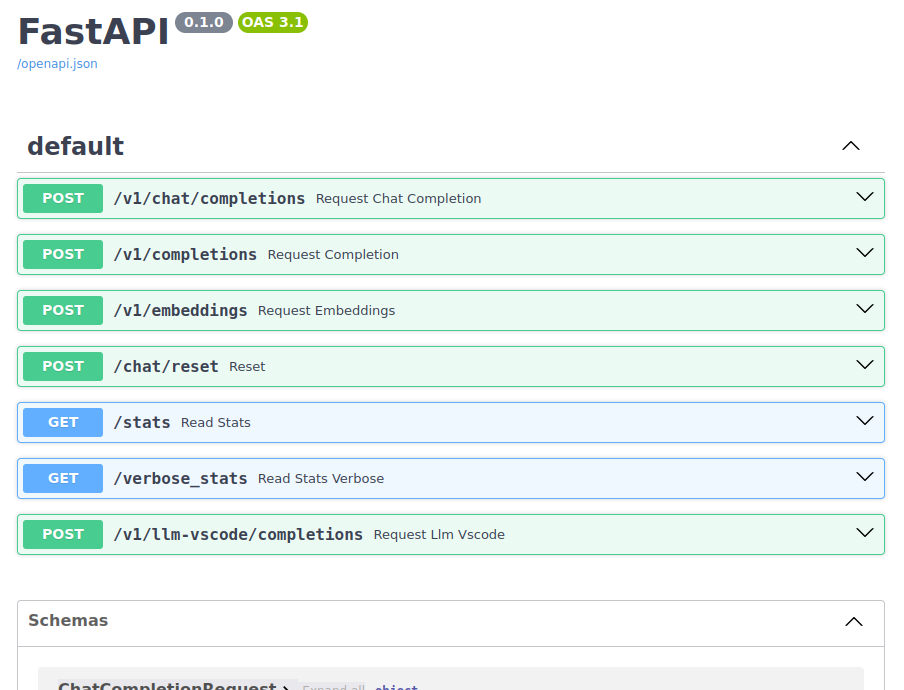
</div>

### Call the Rest API

In [ ]:
from datasets import load_dataset
from random import randrange

dataset = load_dataset("samsum", split='validation')

In [2]:
sample = dataset[10]

prompt = f"""### Instruction:
You are a helpful, respectful and honest assistant. \
Your task is to summarize the following dialogue. \
Your answer should be based on the provided dialogue only.

### Dialogue:
{sample['dialogue']}

### Summary:
"""
print(prompt)

### Instruction:
You are a helpful, respectful and honest assistant. Your task is to summarize the following dialogue. Your answer should be based on the provided dialogue only.

### Dialogue:
Laura: I need a new printer :/
Laura: thinking about this one
Laura: <file_other>
Jamie: you're sure you need a new one?
Jamie: I mean you can buy a second hand one
Laura: could be

### Summary:



In [4]:
import openai
openai.api_key = "none"
openai.api_base = "http://127.0.0.1:9000/v1"

In [11]:
completion = openai.ChatCompletion.create(
  model='none',
  messages=[{"role": "user", "content": prompt}]
)
print(completion.choices[0].message.content)

Laura is considering purchasing a new printer, but is unsure if it's necessary. Jamie suggests buying a second-hand printer as an alternative. Laura is open to the idea but wants to explore more options before making a decision.
